In [455]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

#https://www.youtube.com/watch?v=QmgJmh2I3Fw

In [470]:
def NormalizeData(data):
    return (data-data.min()) / (data.max()-data.min())
    #return data

def normalize(datas):
    return (datas-np.mean(datas))/np.std(datas)

def norm(data):
    trans = RobustScaler()
    return trans.fit_transform(data.reshape(-1, 1)).reshape(1,-1)

In [457]:
masks = glob("D:/instru_projects/TimeSeriesAnalysis/*/*/*/*/*.npy")
len(masks)

426

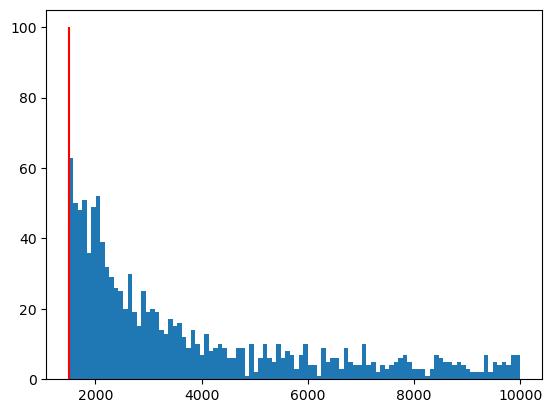

In [641]:
data = np.array(data_dict["area"])
data = data[data < 0.1*10**5]
_ = plt.hist(data, bins = 100)
plt.vlines(1500, 0,100, color = "red")


In [636]:
data_dict = {"path":[], "area": [], "perimeter": [] ,"label":[],"day":[],
             "conc":[],"cnt":[], "pixelSize": [], "time":[], 
             "run_num":[], "condition": []} 

run_num = 0
for i in range(len(masks)):
    path = masks[i]
    path = os.path.normpath(path)
    parts = path.split(os.sep)
    try:
        name = parts[-1][:-8]
        time = parts[-2]
        if len(time) > 4:
            time = time[:-5]
        else:
            time = time[:-1]
        conc = parts[-3]
        label = parts[-4]
        day = parts[-5].split("_")[0]
        m = 3.45/(int(parts[-1].split("_")[0][:-1]))
    except:
        print("incorrect naming:", path)

    seg = np.load(path,allow_pickle=True).item()
    cnt, _ = cv2.findContours(seg["outlines"].astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    for k in range(len(cnt)):

        area = cv2.contourArea(cnt[k])
        contReal = cv2.arcLength(cnt[k],True)
        if area < 1500:
            continue

        data_dict["path"].append(i)
        data_dict["perimeter"].append(contReal)
        data_dict["label"].append(label)
        data_dict["day"].append(day)
        data_dict["cnt"].append(cnt[k])
        data_dict["pixelSize"].append(m)
        data_dict["time"].append(time)
        data_dict["run_num"].append(run_num)
        data_dict["conc"].append(conc)
        data_dict["area"].append(area)
        run_num += run_num

In [637]:
def normalize_efd(coeffs, size_invariant=True, return_transformation=False):
    """Normalizes an array of Fourier coefficients.

    See [#a]_ and [#b]_ for details.

    :param numpy.ndarray coeffs: A ``[n x 4]`` Fourier coefficient array.
    :param bool size_invariant: If size invariance normalizing should be done as well.
        Default is ``True``.
    :param bool return_transformation: If the normalization parametres should be returned.
        Default is ``False``.
    :return: The normalized ``[n x 4]`` Fourier coefficient array and optionally the
        transformation parametres ``scale``, :math:`psi_1` (rotation) and :math:`theta_1` (phase)
    :rtype: :py:class:`numpy.ndarray` or (:py:class:`numpy.ndarray`, (float, float, float))

    """
    # Make the coefficients have a zero phase shift from
    # the first major axis. Theta_1 is that shift angle.
    theta_1 = 0.5 * np.arctan2(
        2 * ((coeffs[0, 0] * coeffs[0, 1]) + (coeffs[0, 2] * coeffs[0, 3])),
        (
            (coeffs[0, 0] ** 2)
            - (coeffs[0, 1] ** 2)
            + (coeffs[0, 2] ** 2)
            - (coeffs[0, 3] ** 2)
        ),
    )
    # Rotate all coefficients by theta_1.
    for n in range(1, coeffs.shape[0] + 1):
        coeffs[n - 1, :] = np.dot(
            np.array(
                [
                    [coeffs[n - 1, 0], coeffs[n - 1, 1]],
                    [coeffs[n - 1, 2], coeffs[n - 1, 3]],
                ]
            ),
            np.array(
                [
                    [np.cos(n * theta_1), -np.sin(n * theta_1)],
                    [np.sin(n * theta_1), np.cos(n * theta_1)],
                ]
            ),
        ).flatten()

    # Make the coefficients rotation invariant by rotating so that
    # the semi-major axis is parallel to the x-axis.
    psi_1 = np.arctan2(coeffs[0, 2], coeffs[0, 0])
    psi_rotation_matrix = np.array(
        [[np.cos(psi_1), np.sin(psi_1)], [-np.sin(psi_1), np.cos(psi_1)]]
    )
    # Rotate all coefficients by -psi_1.
    for n in range(1, coeffs.shape[0] + 1):
        coeffs[n - 1, :] = psi_rotation_matrix.dot(
            np.array(
                [
                    [coeffs[n - 1, 0], coeffs[n - 1, 1]],
                    [coeffs[n - 1, 2], coeffs[n - 1, 3]],
                ]
            )
        ).flatten()

    size = coeffs[0, 0]
    if size_invariant:
        # Obtain size-invariance by normalizing.
        coeffs /= np.abs(size)

    if return_transformation:
        return coeffs, (size, psi_1, theta_1)
    else:
        return coeffs

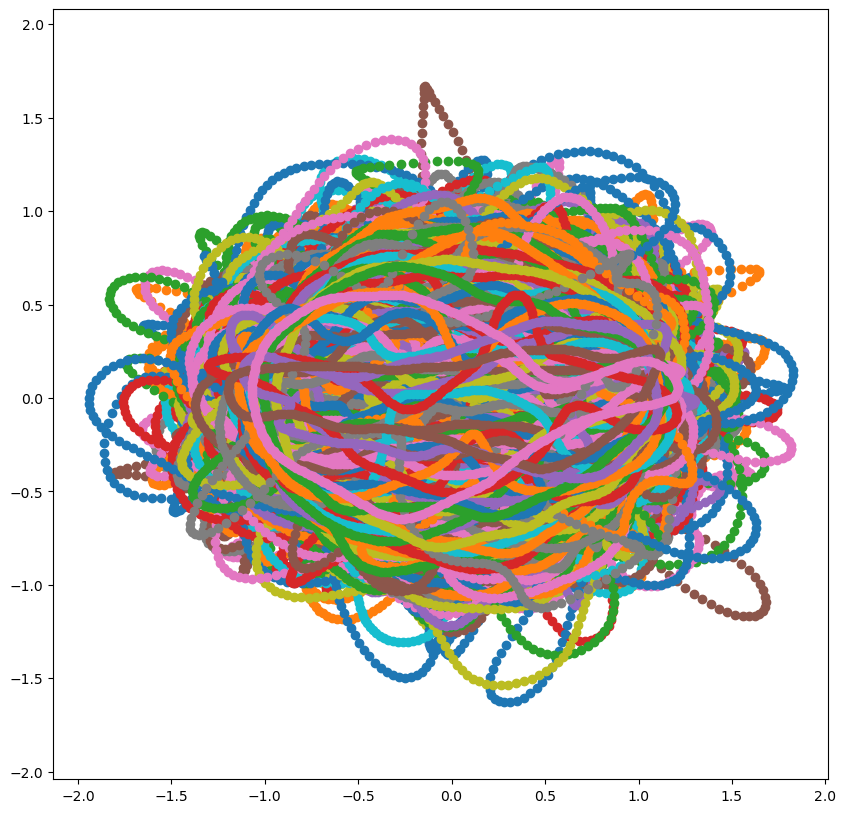

In [638]:
##
order = 15
n_iter = 300
locus=(0.0, 0.0)
normalize = True

data_dict["coeffs"] = []
tempDict = {}

exp_flag = True

if exp_flag:
    r_x_list = np.array(list(map(lambda x: "r_x_" + x, np.arange(order).astype("str"))))
    r_y_list = np.array(list(map(lambda x: "r_y_" + x, np.arange(order).astype("str"))))
    for i in range(order):  
        tempDict[r_x_list[i]] = []
        tempDict[r_y_list[i]] = []
else:
    a_list = np.array(list(map(lambda x: "a_" + x, np.arange(order).astype("str"))))
    b_list = np.array(list(map(lambda x: "b_" + x, np.arange(order).astype("str"))))
    c_list = np.array(list(map(lambda x: "c_" + x, np.arange(order).astype("str"))))
    d_list = np.array(list(map(lambda x: "d_" + x, np.arange(order).astype("str"))))
    for i in range(order):  
        tempDict[a_list[i]] = []
        tempDict[b_list[i]] = []
        tempDict[c_list[i]] = []
        tempDict[d_list[i]] = []


fig, ax = plt.subplots(1,1, figsize = (10,10))
for k in range(len(data_dict["cnt"])):
    #coords
    contour = np.array(data_dict["cnt"][k][:,0,:])
    
    if contour.shape[0] <= 2:
        data_dict["coeffs"].append(np.zeros((order,4)))
        continue
        
    #M = cv2.moments(contour)
    #cX = int(M["m10"] / M["m00"])
    #cY = int(M["m01"] / M["m00"])
    
    dxy = np.diff(contour, axis = 0 )
    

    #time
    dt = np.sqrt((dxy ** 2).sum(axis=1))
    t = np.concatenate([([0.0]), np.cumsum(dt)])
    T = t[-1]

    phi = 2*np.pi*t/T

    orders = np.arange(1, order + 1)
    consts = T / (2 * orders * orders * np.pi * np.pi)
    
    phi = phi * orders.reshape((order, -1))

    d_cos_phi = np.cos(phi[:, 1:]) - np.cos(phi[:, :-1])
    d_sin_phi = np.sin(phi[:, 1:]) - np.sin(phi[:, :-1])

    a = consts * np.sum((dxy[:, 0] / dt) * d_cos_phi, axis=1)
    b = consts * np.sum((dxy[:, 0] / dt) * d_sin_phi, axis=1)
    c = consts * np.sum((dxy[:, 1] / dt) * d_cos_phi, axis=1)
    d = consts * np.sum((dxy[:, 1] / dt) * d_sin_phi, axis=1)

    coeffs = np.concatenate(
        [
            a.reshape((order, 1)),
            b.reshape((order, 1)),
            c.reshape((order, 1)),
            d.reshape((order, 1)),
        ],
        axis=1,
    )
    
    coeffs = normalize_efd(coeffs)
    
    data_dict["coeffs"].append(coeffs)

    xi = np.cumsum(dxy[:, 0]) - (dxy[:, 0] / dt) * t[1:]
    A0 = (1 / T) * np.sum(((dxy[:, 0] / (2 * dt)) * np.diff(t ** 2)) + xi * dt)
    delta = np.cumsum(dxy[:, 1]) - (dxy[:, 1] / dt) * t[1:]
    C0 = (1 / T) * np.sum(((dxy[:, 1] / (2 * dt)) * np.diff(t ** 2)) + delta * dt)

    a0 =contour[0, 0] + A0
    c0 = contour[0, 1] + C0

    N_tot = coeffs.shape[0]
    N_half = int(np.ceil(N_tot / 2))
    n_rows = 2

    t = np.linspace(0, 1.0, n_iter)
    xt = np.ones((n_iter,)) * locus[0]
    yt = np.ones((n_iter,)) * locus[1]
    
    for n in range(coeffs.shape[0]):
        xt += (coeffs[n, 0] * np.cos(2 * (n + 1) * np.pi * t)) + (
            coeffs[n, 1] * np.sin(2 * (n + 1) * np.pi * t)
        )
        yt += (coeffs[n, 2] * np.cos(2 * (n + 1) * np.pi * t)) + (
            coeffs[n, 3] * np.sin(2 * (n + 1) * np.pi * t)
        )

        #ax = plt.subplot2grid((n_rows, N_half), (n // N_half, n % N_half))
        #ax.set_title(str(n + 1))
        if n == coeffs.shape[0]-1:
            #ax.plot(contour[:, 0]-cX, contour[:, 1]-cY, "c--", linewidth=2)
            ax.scatter(xt, yt)
            ax.axis("equal")

plt.show()

for i in range(len(data_dict["coeffs"])):
    for j in range(order):
        if exp_flag:
            tempDict[r_x_list[j]].append(np.sqrt(data_dict["coeffs"][i][j,0]**2+data_dict["coeffs"][i][j,1]**2))
            tempDict[r_y_list[j]].append(np.sqrt(data_dict["coeffs"][i][j,2]**2+data_dict["coeffs"][i][j,3]**2))
        else:
            tempDict[a_list[j]].append(data_dict["coeffs"][i][j,0])
            tempDict[b_list[j]].append(data_dict["coeffs"][i][j,1])
            tempDict[c_list[j]].append(data_dict["coeffs"][i][j,2])
            tempDict[d_list[j]].append(data_dict["coeffs"][i][j,3])
            
df_pca = pd.DataFrame.from_dict(tempDict)
df_pca = df_pca.replace(np.nan, 0)

pca = PCA(n_components=3,whiten = True)
pca = pca.fit(df_pca)
components = pca.fit_transform(df_pca)
comp = pd.DataFrame(components, columns = ['1','2','3'])

Text(0.5, 0, 'Var [Idx]')

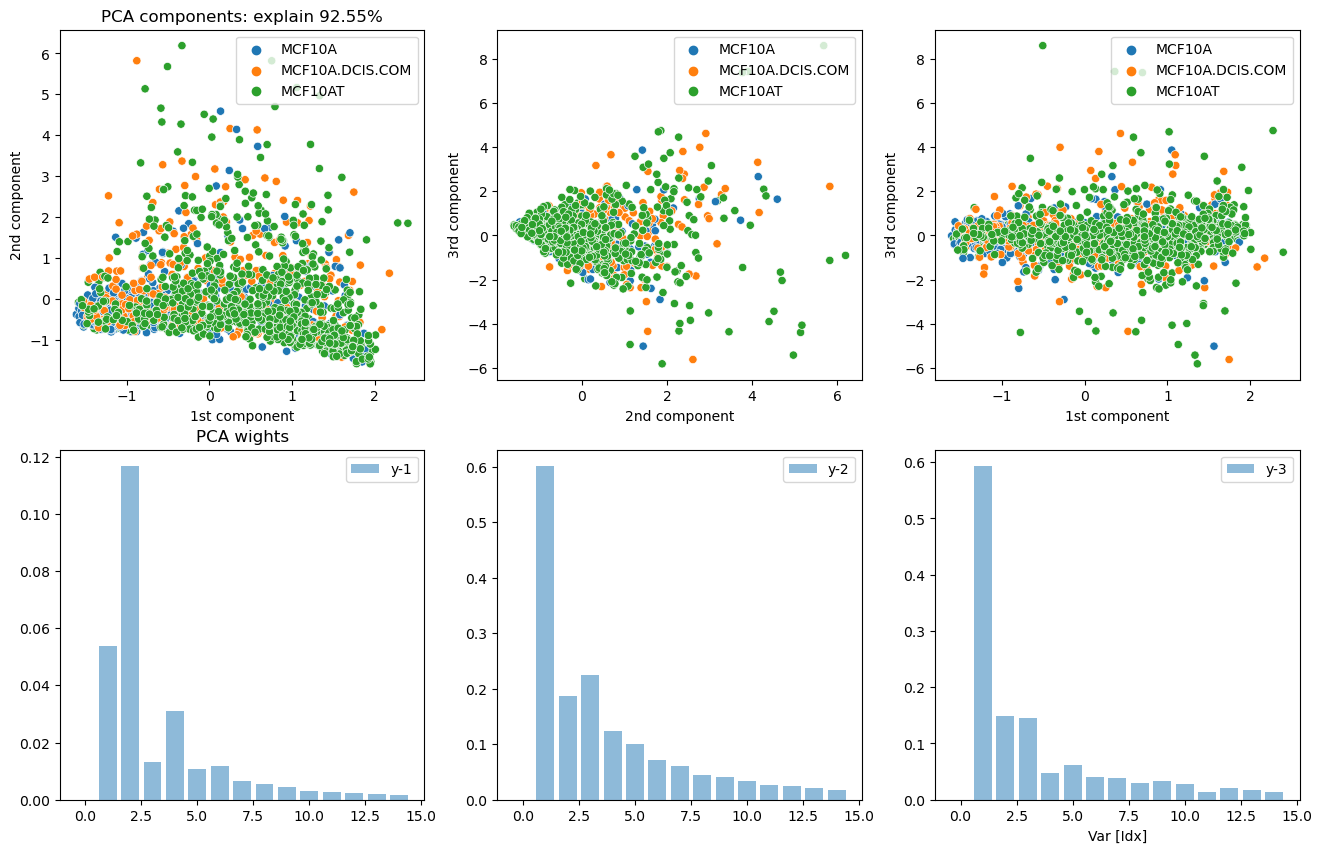

In [640]:
fig, ax = plt.subplots(2, 3,figsize=(16, 10),facecolor='white')

comp = pd.DataFrame(components, columns = ['1','2','3'])
extra =['label', 'day', 'conc', 'run_num', 'pixelSize', 'time']
for i in extra:
    comp[i] = data_dict[i]
    
total_var = pca.explained_variance_ratio_.sum() * 100

ax[0,0].set_title("PCA components: explain {:.2f}%".format(total_var))
ax[0,0].set_xlabel("1st component")
ax[0,0].set_ylabel("2nd component")
sns.scatterplot(x='1', y='2', data=comp, ax = ax[0,0], hue = "label")
ax[0,0].legend(loc='upper right')

ax[0,1].set_xlabel("2nd component")
ax[0,1].set_ylabel("3rd component")
sns.scatterplot(x='2', y='3', data=comp, ax = ax[0,1],  hue = "label")
ax[0,1].legend(loc='upper right')

ax[0,2].set_xlabel("1st component")
ax[0,2].set_ylabel("3rd component")
sns.scatterplot(x='1', y='3', data=comp, ax = ax[0,2],  hue = "label")
ax[0,2].legend(loc='upper right')

weights = pca.components_

ax[1,0].set_title("PCA wights")
ax[1,0].bar(np.arange(0,len(weights[0,::2])),weights[0,::2], label = "y-1", alpha = 0.5)
#ax[1,0].bar(np.arange(0,len(weights[0,1::2])),weights[0,1::2], label = "y-1", alpha = 0.5)
ax[1,0].legend()

ax[1,1].bar(np.arange(0,len(weights[0,::2])),weights[1,::2], label = "y-2", alpha = 0.5)
#ax[1,1].bar(np.arange(0,len(weights[0,1::2])),weights[1,1::2], label = "y-2", alpha = 0.5)
ax[1,1].legend()

ax[1,2].bar(np.arange(0,len(weights[0,::2])),weights[2,::2], label = "y-3", alpha = 0.5)
#ax[1,2].bar(np.arange(0,len(weights[0,1::2])),weights[2,1::2], label = "y-3", alpha = 0.5)
ax[1,2].legend()

ax[1,2].set_xlabel("Var [Idx]")
ax[1,2].set_xlabel("Var [Idx]")
ax[1,2].set_xlabel("Var [Idx]")

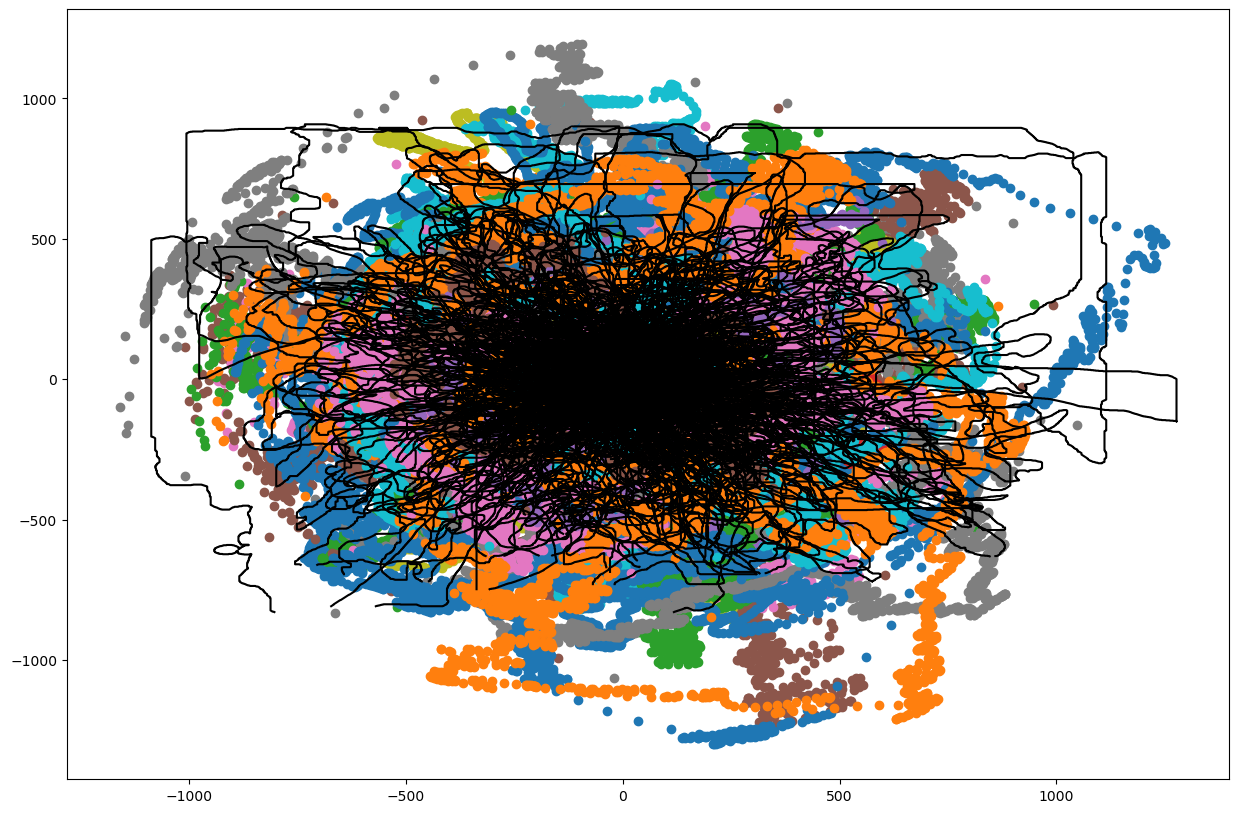

In [605]:
order = 20
pw_tot = []
tempDict = {}
data_dict["pw"] = []
data_dict["freqs"] = []
longest = 0

polar = True
gradient = False
fig, ax = plt.subplots(1, 1,figsize=(15, 10),facecolor='white')

for k in range(len(data_dict["cnt"])):
    #coords
    contour = np.array(data_dict["cnt"][k][:,0,:])
    xx = contour.astype(np.float32)
    
    if xx.shape[0] <= 2:
        data_dict["pw"].append(np.zeros((1,2)))
        continue
        
    if xx.shape[0]%2 != 0:
        xx = xx[:-1]
    xx = xx.astype(np.float32)-np.mean(xx,axis=0)[None,...]

    yy = xx.copy()
    if polar:
        #convert to polar
        r = np.sqrt(xx[:,0]**2 + xx[:,1]**2)


        phi = np.unwrap(np.arctan2(xx[:,1],xx[:,0]))#np.unwrap()
        if gradient:
            r = np.gradient(r)
            phi = np.gradient(phi)
        phi -= np.mean(phi)
        #phi = np.gradient(phi)
        yy[:,0] = r
        yy[:,1] = phi
    else:
        if gradient:
            yy = np.gradient(xx, axis = 0)

    #xx[:,0] = scipy.ndimage.gaussian_filter(r,5)
    #xx[:,1] = scipy.ndimage.gaussian_filter(phi,5)
    
    
    N = xx.shape[0]
    threshold = 400
    mirror = int(N/2)
    #N = 50
    
    #for count,threshold in enumerate(range(order)):
        
    fft_xy = np.fft.fft(yy, axis = 0)
    pw = np.abs(fft_xy)**2

    idx = np.argsort(pw,axis=0)[::-1]
    n = idx[:threshold]
    sub_sig = np.zeros((N,2),dtype=np.complex128)
    sub_sig[n] = fft_xy[n]

    i_sig = np.real(np.fft.ifft(sub_sig,axis=0) )
    
    pw = np.abs(sub_sig)**2/N # power densinty
    t = np.arange(N)
    freq = np.fft.fftfreq(t.shape[-1])

    #if count == 0:
    ax.plot(xx[:,0],xx[:,1],color = "black", label = "Contour")

    #ax.scatter(i_sig[:,0],i_sig[:,1], label = "Component {}".format(count))
    ax.scatter(np.cos(i_sig[:,1])*i_sig[:,0],np.sin(i_sig[:,1])*i_sig[:,0], label = "Component {}".format(count))
        
    pos_freq = np.where(freq>0)[0]
    neg_freq = np.where(freq<0)[0]



    
    pw_pos = pw[pos_freq,:]
    pw_neg = pw[np.flip(neg_freq)[:-1],:] #zero is not 
    pw = np.concatenate((pw[0,:].reshape(1,2),pw_pos)) #+pw_neg
    #pw[:,0] = NormalizeData(pw[:,0])
    #pw[:,1] = NormalizeData(pw[:,1])
    
    if pw.shape[0] < 25:
        #r_norm = NormalizeData(pw[:,0])
        #phi_norm  = NormalizeData(pw[:,1])
        r_norm = pw[:,0]
        phi_norm  = pw[:,1]
        data_dict["pw"].append(np.stack((r_norm,phi_norm), axis = -1))
    else:
        #r_norm = NormalizeData(pw[:order,0])
        #phi_norm = NormalizeData(pw[:order,1])
        r_norm = pw[:order,0]
        phi_norm  = pw[:order,1]
        data_dict["pw"].append(np.stack((r_norm,phi_norm), axis = -1))
        longest = data_dict["pw"][-1].shape[0]
        pos_freqs = freq[pos_freq]
        
    
#headerR = np.array(list(map(lambda x: "r_" + x,np.arange(longest).astype("str"))))
headerPhi = np.array(list(map(lambda x: "p_" + x, np.arange(longest).astype("str"))))

#for i in range(longest):
#    tempDict[headerR[i]] = []
for i in range(longest):  
    tempDict[headerPhi[i]] = []

for i in range(len(data_dict["pw"])):
    for j in range(longest):
        if data_dict["pw"][i].shape[0] <= j:
            #tempDict[headerR[j]].append(0)
            tempDict[headerPhi[j]].append(0)
        else:
            #tempDict[headerR[j]].append(data_dict["pw"][i][j,0])
            tempDict[headerPhi[j]].append(data_dict["pw"][i][j,1])

for i in tempDict.keys():
    tempDict[i] = NormalizeData(np.array(tempDict[i]))
    
df_pca = pd.DataFrame.from_dict(tempDict)
df_pca = df_pca.replace(np.nan, 0)

pca = PCA(n_components=3,whiten = True)
pca = pca.fit(df_pca)
components = pca.fit_transform(df_pca)
comp = pd.DataFrame(components, columns = ['1','2','3'])


Text(0.5, 0, 'Var [Idx]')

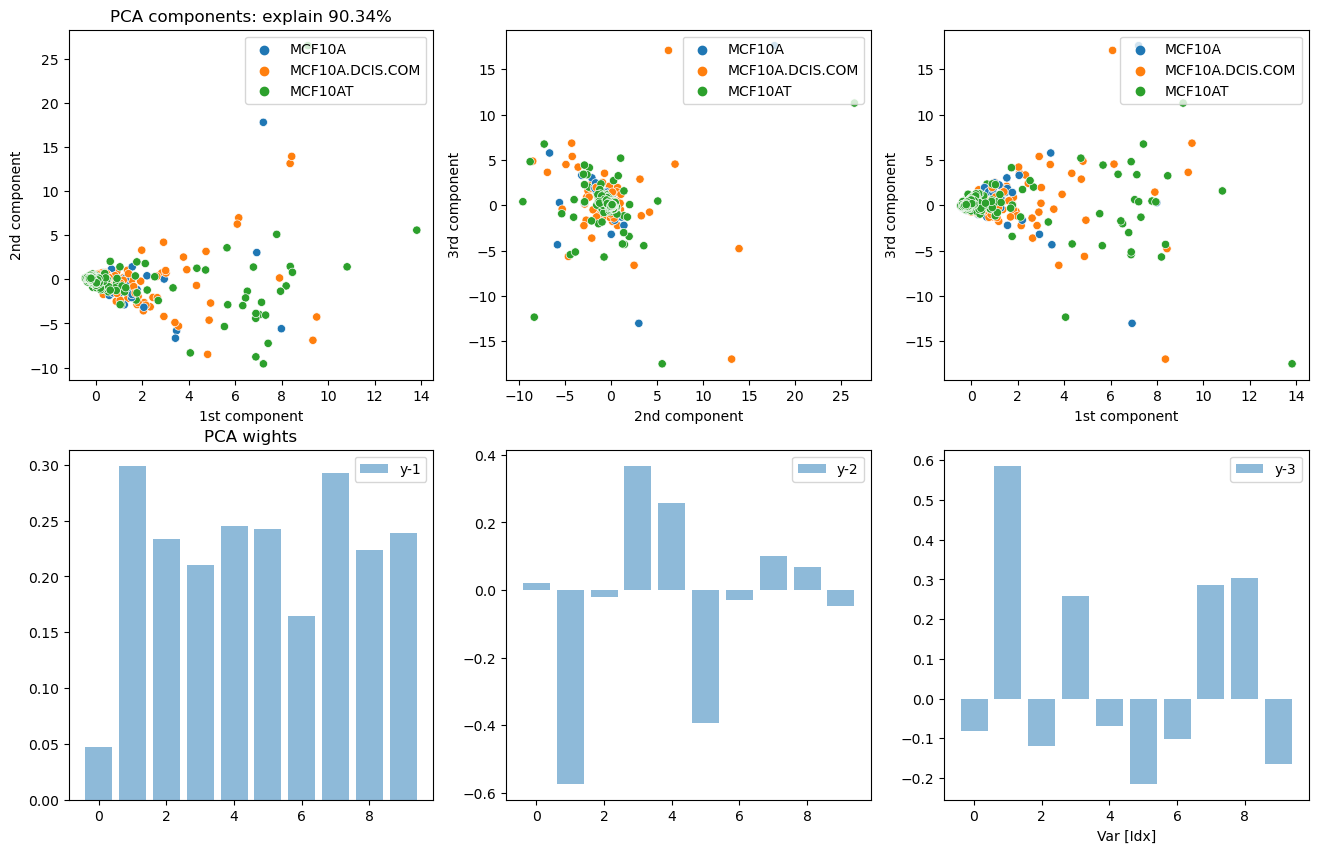

In [606]:
fig, ax = plt.subplots(2, 3,figsize=(16, 10),facecolor='white')

comp = pd.DataFrame(components, columns = ['1','2','3'])
extra =['label', 'day', 'conc', 'time','run_num', 'pixelSize']
for i in extra:
    comp[i] = data_dict[i]
    
total_var = pca.explained_variance_ratio_.sum() * 100

ax[0,0].set_title("PCA components: explain {:.2f}%".format(total_var))
ax[0,0].set_xlabel("1st component")
ax[0,0].set_ylabel("2nd component")
sns.scatterplot(x='1', y='2', data=comp, ax = ax[0,0], hue = "label")
ax[0,0].legend(loc='upper right')

ax[0,1].set_xlabel("2nd component")
ax[0,1].set_ylabel("3rd component")
sns.scatterplot(x='2', y='3', data=comp, ax = ax[0,1],  hue = "label")
ax[0,1].legend(loc='upper right')

ax[0,2].set_xlabel("1st component")
ax[0,2].set_ylabel("3rd component")
sns.scatterplot(x='1', y='3', data=comp, ax = ax[0,2],  hue = "label")
ax[0,2].legend(loc='upper right')

weights = pca.components_

ax[1,0].set_title("PCA wights")
ax[1,0].bar(np.arange(0,len(weights[0,::2])),weights[0,::2], label = "y-1", alpha = 0.5)
#ax[1,0].bar(np.arange(0,len(weights[0,1::2])),weights[0,1::2], label = "y-1", alpha = 0.5)
ax[1,0].legend()

ax[1,1].bar(np.arange(0,len(weights[0,::2])),weights[1,::2], label = "y-2", alpha = 0.5)
#ax[1,1].bar(np.arange(0,len(weights[0,1::2])),weights[1,1::2], label = "y-2", alpha = 0.5)
ax[1,1].legend()

ax[1,2].bar(np.arange(0,len(weights[0,::2])),weights[2,::2], label = "y-3", alpha = 0.5)
#ax[1,2].bar(np.arange(0,len(weights[0,1::2])),weights[2,1::2], label = "y-3", alpha = 0.5)
ax[1,2].legend()

ax[1,2].set_xlabel("Var [Idx]")
ax[1,2].set_xlabel("Var [Idx]")
ax[1,2].set_xlabel("Var [Idx]")